In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import sys
sys.path.append("../..")
from pathlib import Path

from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_score
warnings.filterwarnings('ignore')

from src.data import label_to_string, string_to_label, DataPaths
from src.image import get_image_with_id, get_image_from_class, plot_rgby

#### Load in the results file and combine the training logs

In [118]:
# ROOT_PATH = Path("results/iafoss_resnet34_20181213-194553/training_logs")
ROOT_PATH = Path("results/gapnet_resnet34_20181213-193008/training_logs")

In [119]:
csv_paths = sorted(ROOT_PATH.glob("*.csv"), key=lambda x: int(x.stem.split("_")[1]))

In [121]:
string_to_num = lambda x: np.fromstring(x.strip("[]").replace("\n", ""), sep=" ")
def load_combined_df(paths):
    dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['session'] = path.stem
        df['label'] = df['label'].map(string_to_num)
        df['label_class'] = df["label"].map(lambda x: np.where(x == 1)[0])
        df['label_names'] = df["label_class"].map(lambda x: [label_to_string[l] for l in x])
        df['prediction'] = df['prediction'].map(string_to_num)
        df['prediction_probs'] = df['prediction_probs'].map(string_to_num)
        df['prediction_class'] = df['prediction'].map(lambda x: np.where(x == 1)[0])
        df['prediction_names'] = df['prediction_class'].map(lambda x: [label_to_string[l] for l in x])
        
        dfs.append(df)
    return pd.concat(dfs)

In [120]:
csv_paths

[PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_0_train.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_0_val.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_1_val.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_1_train.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_2_val.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_2_train.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_3_val.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_3_train.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_4_val.csv'),
 PosixPath('results/gapnet_resnet34_20181213-193008/training_logs/epoch_4_train.csv')]

In [122]:
combined_df = load_combined_df(csv_paths)

#### Calculate the f1 score for each class, and the f1 micro/macro for each epoch

In [124]:
def get_session_df(df, session):
    return df[df['session'] == session]

def get_metric_df(df):
    metric_data = []
    all_labels = np.stack(df.label.values)
    all_predictions = np.stack(df.prediction.values)
    for i in range(28):
        (_, precision), (_, recall), (_, f1_score), (_, n_labels)  = precision_recall_fscore_support(all_labels[:,i], all_predictions[:,i])
        data = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "n_labels": n_labels,
            "class_name": label_to_string[i]
        }
        metric_data.append(data)
    metric_df = pd.DataFrame(metric_data)
    metric_df = metric_df.reindex_axis(['class_name', 'n_labels', 'precision', 'recall', 'f1_score'], axis=1)
    return metric_df

In [125]:
def create_combined_sessions_metrics_df(combined_df, sessions):
    metrics_df = []
    for s in tqdm_notebook(sessions):
        df = get_session_df(combined_df, s)
        metric_df = get_metric_df(df)
        metric_df['session'] = s
        metrics_df.append(metric_df)
    return pd.concat(metrics_df)

In [126]:
def create_combined_sessions_f1_score_df(comibined_df, sessions):
    f1_score_data = []
    for s in tqdm_notebook(sessions):
        df = get_session_df(combined_df, s)
        all_labels = np.stack(df.label.values)
        all_predictions = np.stack(df.prediction.values)
        micro_f1 = f1_score(all_labels, all_predictions, average='micro')
        macro_f1 = f1_score(all_labels, all_predictions, average='macro')
        f1_score_data.append(dict(micro_f1=micro_f1, macro_f1=macro_f1))
    return pd.DataFrame(f1_score_data).reindex_axis(['micro_f1', 'macro_f1'], axis=1)

In [127]:
train_sessions = [s for s in combined_df['session'].unique() if 'train' in s]
val_sessions = [s for s in combined_df['session'].unique() if 'val' in s]

In [128]:
train_metrics_df = create_combined_sessions_metrics_df(combined_df, train_sessions)
val_metrics_df = create_combined_sessions_metrics_df(combined_df, val_sessions)

In [129]:
train_f1_score_df = create_combined_sessions_f1_score_df(combined_df, train_sessions)
val_f1_score_df = create_combined_sessions_f1_score_df(combined_df, val_sessions)

In [130]:
train_f1_score_df

,micro_f1,macro_f1
0,0.452587,0.098613
1,0.535275,0.174625
2,0.564298,0.213621
3,0.579095,0.235133
4,0.590013,0.251122


In [131]:
val_f1_score_df

,micro_f1,macro_f1
0,0.525461,0.201364
1,0.540835,0.237678
2,0.560096,0.293497
3,0.603305,0.319838
4,0.631993,0.331472


In [132]:
import seaborn as sns

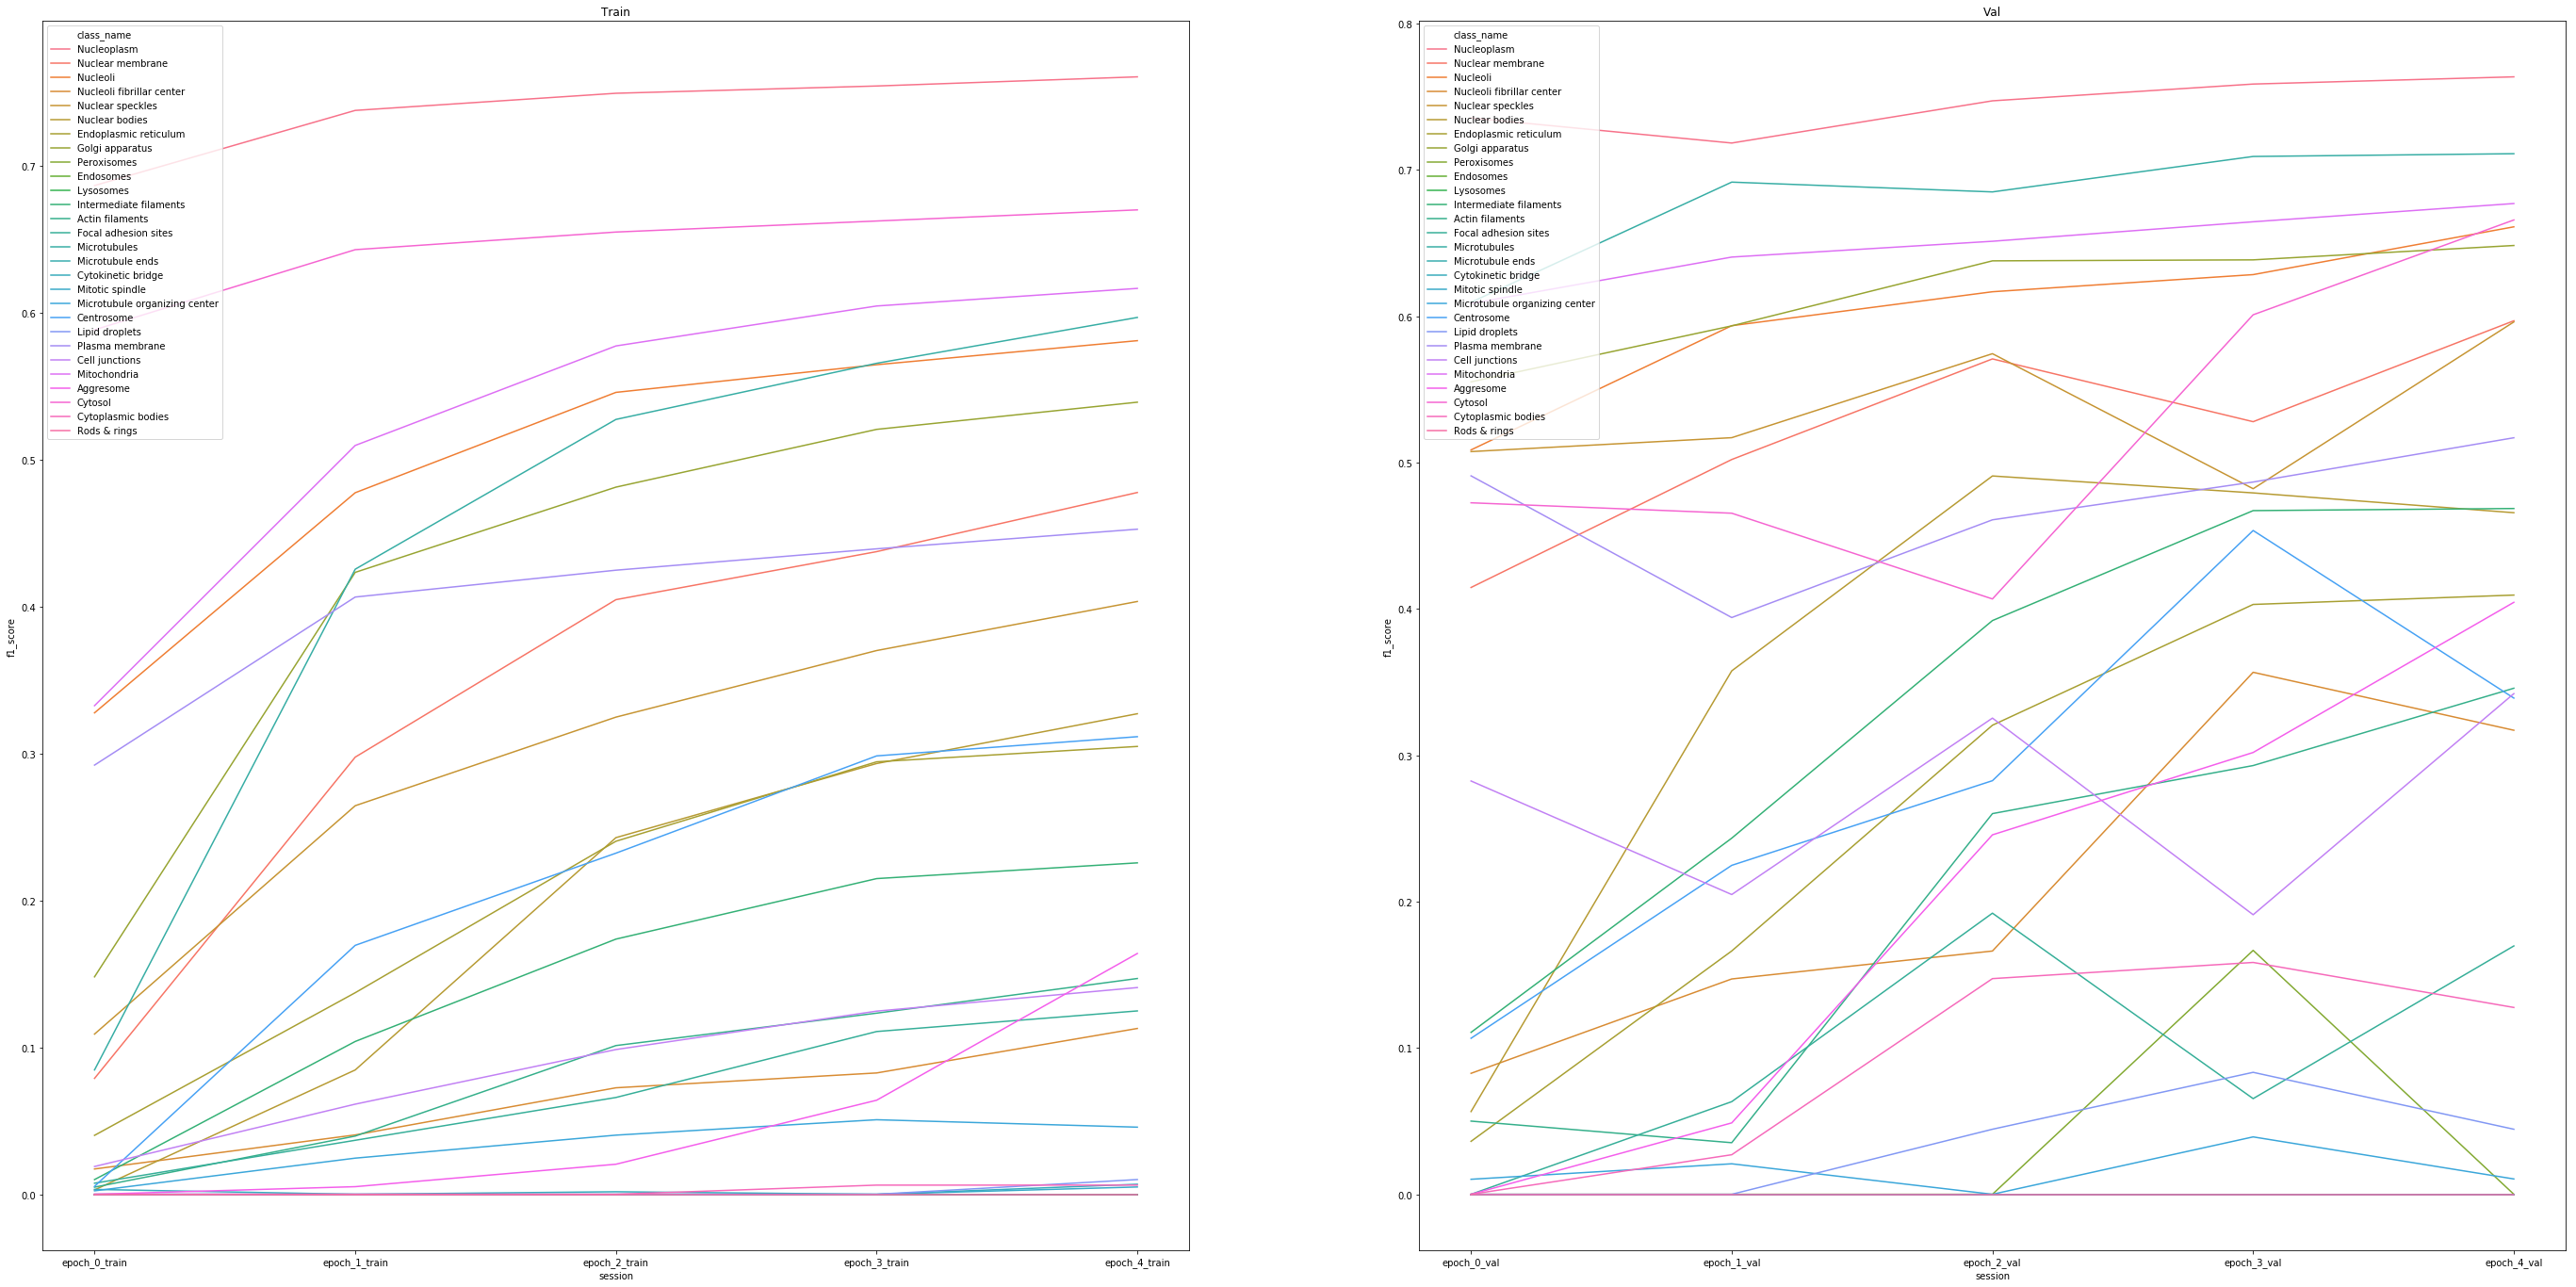

In [133]:
_, axs = plt.subplots(1, 2, figsize=(48, 24))
axs[0].set_title("Train")
sns.lineplot(x="session", y="f1_score", hue="class_name", data=train_metrics_df, legend="full", ax=axs[0])
axs[1].set_title("Val")
sns.lineplot(x="session", y="f1_score", hue="class_name", data=val_metrics_df, legend="full", ax=axs[1])